# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) which allows PINTS users access to Stan model log-probability density calculations and gradient calculations (via autodiff). In doing so, it gives users in PINTS the benefits of using Stan's large family of probability distributions to construct their model. The model can then be run using PINTS' samplers and optimisers.

One thing to be mindful of is that the interface below only allows the log-probability density to be accessed from Stan objects up to an additive constant. Another is that Stan operates on the unconstrained scale, so the PINTS interface to Stan passes and receives parameter draws on this scale.

In this notebook, we use two examples:

- a simple Gaussian example: which shows the basics of how the interface works
- the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html): which shows how it is possible to fit hierarchical models coded in Stan within PINTS

## Gaussian example

In [1]:
import pints
import pints.toy
from pints.interfaces.stan import StanLogPDF
import pystan
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

ModuleNotFoundError: No module named 'pystan'

In [2]:
code = '''
        data {
  int<lower=0> N;
  real y[N];
}
parameters {
  real mu;
  real sigma; 
}
model {
  y ~ normal(mu, sigma);
}'''

First compile a Stan model.

In [3]:
stanmodel = StanLogPDF(stan_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_694e923a257c6a10986d5789af2b176d NOW.


Then create a Stan model fit object that can be called by PINTS.

In [4]:
data = {'N':10, 'y':np.random.normal(size=10)}
stanmodel.update_data(data)

/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Note that different data can be fed into this object to create different LogPDFs.

In [5]:
x = [1, 2]
print("old data log-pdf = ", stanmodel(x))

# create new random y
data = {'N':10, 'y':np.random.normal(size=10)}
stanmodel.update_data(data)
print("new data log-pdf = ", stanmodel(x))

old data log-pdf =  -12.230573466882388
new data log-pdf =  -8.973185855453288


Now run a PINTS' [Haario-Bardenet ACMC](sampling/adaptive-covariance-haario-bardenet.ipynb) sampler using the Stan model.

In [6]:
# initialise
xs = [np.random.uniform(size=2,low=0.2, high=1) for chain in range(4)]
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(2000)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0         0.5       0.5        0:00.0
2     12     0.667     0.333     0.667     0.667      0:00.0
3     16     0.75      0.5       0.75      0.5        0:00.0
Initial phase completed.
2000  8004   0.285     0.28      0.276     0.285      0:02.4
4000  16004  0.25      0.264     0.254     0.257      0:04.8
6000  24004  0.249     0.246     0.245     0.245959   0:07.2
8000  32004  0.241     0.241     0.243     0.244      0:09.6
10000 40000  0.2443    0.2444    0.2377    0.2395     0:12.0
Halting: Maximum number of iterations (10000) reached.
Done!


In [7]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start),
                            parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mu       0.01    0.33    -0.64   -0.20  0.01   0.21   0.66     1.00    3399.69  283.23
sigma    0.99    0.29    0.61    0.80   0.93   1.13   1.71     1.00    2526.55  210.49


### Constrained $\sigma$
We now illustrate how constraining $\sigma$ results in a changed behaviour. Stan always samples on the unconstrained scale: it is able to do so because its parameters are always defined with bounds in the `parameters` block. (See https://mc-stan.org/docs/2_26/reference-manual/variable-transforms-chapter.html for a description of the different transforms applied to constrained variables.) The PINTS interface to Stan always supplies parameters on the unconstrained scale. In the below Stan code block, we put a lower bound on $\sigma$. Seeing this, Stan performs a log-transformation on this variable. So the draws we obtain via the Stan interface will be unconstrained.

In [8]:
code1 = '''
        data {
  int<lower=0> N;
  real y[N];
}
parameters {
  real mu;
  real<lower=0> sigma; 
}
model {
  y ~ normal(mu, sigma);
}'''

An alternative way to create a Stan model is to supply the Stan code and data all in one.

In [9]:
stanmodel1 = StanLogPDF(stan_code=code1, stan_data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bb4bff9ca90afdba8fce72619f7509f9 NOW.


Since the $\sigma$ variable is now unconstrained, we are free to pass unconstrained initial values to the sampler.

In [10]:
xs = [np.random.uniform(size=2,low=-1, high=1) for chain in range(4)]

mcmc = pints.MCMCController(stanmodel1, len(xs), xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(2000)

start = time.time()
# Run!
print('Running...')
full_chains1 = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0.5       0.5       0.5       0.5        0:00.0
2     12     0.333     0.667     0.667     0.667      0:00.0
3     16     0.5       0.75      0.5       0.75       0:00.0
Initial phase completed.
2000  8004   0.284     0.283     0.271     0.284      0:02.3
4000  16004  0.254     0.261     0.248     0.254      0:04.7
6000  24004  0.25      0.25      0.245     0.249      0:07.0
8000  32004  0.243     0.246     0.242     0.244      0:09.4
10000 40000  0.2449    0.2416    0.2411    0.2398     0:11.7
Halting: Maximum number of iterations (10000) reached.
Done!


To compare the draws across the two methods, we need to convert back to the constrained space. Note, that the Stan interface takes care of the Jacobian transformations, so we only need to apply the inverse transformation to the samples (the `exp` function).

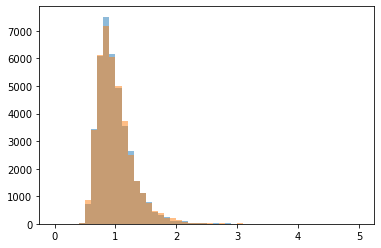

In [11]:
plt.hist(np.vstack(full_chains)[:, 1], bins=np.arange(0, 5 + 0.1, 0.1), alpha=0.5)
plt.hist(np.exp(np.vstack(full_chains1)[:, 1]), bins=np.arange(0, 5 + 0.1, 0.1), alpha=0.5)
plt.show()

## Eight Schools

We now illustrate how to use the Stan interface to sample from the notorious hierarchical eight schools model (the [eight schools](http://localhost:8888/notebooks/pints/examples/toy/distribution-eight-schools.ipynb) notebook for more on its notoriety). First, we use the PINTS [eight schools toy model](https://github.com/pints-team/pints/blob/master/examples/toy/distribution-eight-schools.ipynb) to give us the requisite data.

In [12]:
model = pints.toy.EightSchoolsLogPDF()
model.data()

{'J': 8,
 'y': [28, 8, -3, 7, -1, 1, 18, 12],
 'sigma': [15, 10, 16, 11, 9, 11, 10, 18]}

### Centered model

We first use PINTS' interface to Stan's models to compile the Stan code for the `centered` model (see the [eight schools](http://localhost:8888/notebooks/pints/examples/toy/distribution-eight-schools.ipynb) notebook) and define a PINTS model.

In [13]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

In [14]:
# instantiate Pints version of Stan model
stanmodel = StanLogPDF(stan_code=code, stan_data=model.data())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e11919b5314121a277ebece94b64d05 NOW.


Run the [Relativistic MCMC](../sampling/relativistic-mcmc.ipynb) sampler using this model.

In [15]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(1.0)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0         0         0.333     0.333      0:00.0
2     164    0         0.25      0.5       0.5        0:00.0
3     244    0         0.4       0.6       0.6        0:00.0
400   32004  0         0.943     0.98      0.918      0:04.3
800   64004  0         0.959     0.96      0.935      0:08.6
1200  96004  0         0.953411  0.97      0.936772   0:12.9
1600  128004  0         0.958     0.966     0.937      0:17.2
2000  160004  0         0.953     0.965035  0.914      0:21.4
2400  192004  0         0.941     0.954     0.92       0:25.7
2800  224004  0         0.945     0.957     0.926838   0:30.0
3200  256004  0         0.95      0.958     0.932      0:34.2
3600  288004  0         0.95      0.942     0.934      0:38.5
4000  319924  0         0.953     0.925     0.937      0

Let's print the results of inference. Note here that $\tau$ is on the log-scale, since Stan see its lower about and applies this transformation.

In [16]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start),
                            parameter_names=stanmodel.names())
print(results)

/Volumes/Samsung1.5TB/Github/pints/pints/_diagnostics.py:16: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.mean(x)) / (np.std(x) * np.sqrt(len(x)))


param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu       2.85    3.61    -1.32   -1.21  2.78   5.42   10.24    1.40    nan     nan
tau      -0.12   1.45    -2.06   -2.06  0.13   1.11   2.19     1.64    257.37  6.02
theta.1  4.25    4.86    -1.82   0.40   3.25   6.82   16.58    1.17    132.46  3.10
theta.2  3.27    4.13    -2.77   -0.25  2.72   6.02   12.46    1.20    134.40  3.15
theta.3  2.70    4.12    -4.65   -0.09  2.06   5.45   11.17    1.12    161.28  3.77
theta.4  3.00    4.19    -3.25   -0.81  2.58   5.88   12.03    1.22    167.68  3.92
theta.5  2.73    3.88    -3.67   -0.23  2.11   5.36   11.00    1.15    197.49  4.62
theta.6  3.04    4.05    -3.27   -0.04  2.38   5.68   11.81    1.16    133.34  3.12
theta.7  4.15    4.54    -1.47   -0.01  3.52   6.93   14.92    1.23    136.03  3.18
theta.8  3.57    4.24    -2.96   0.59   2.69   6.03   13.88

The wandering chains here illustrate how difficult inference is for this model.

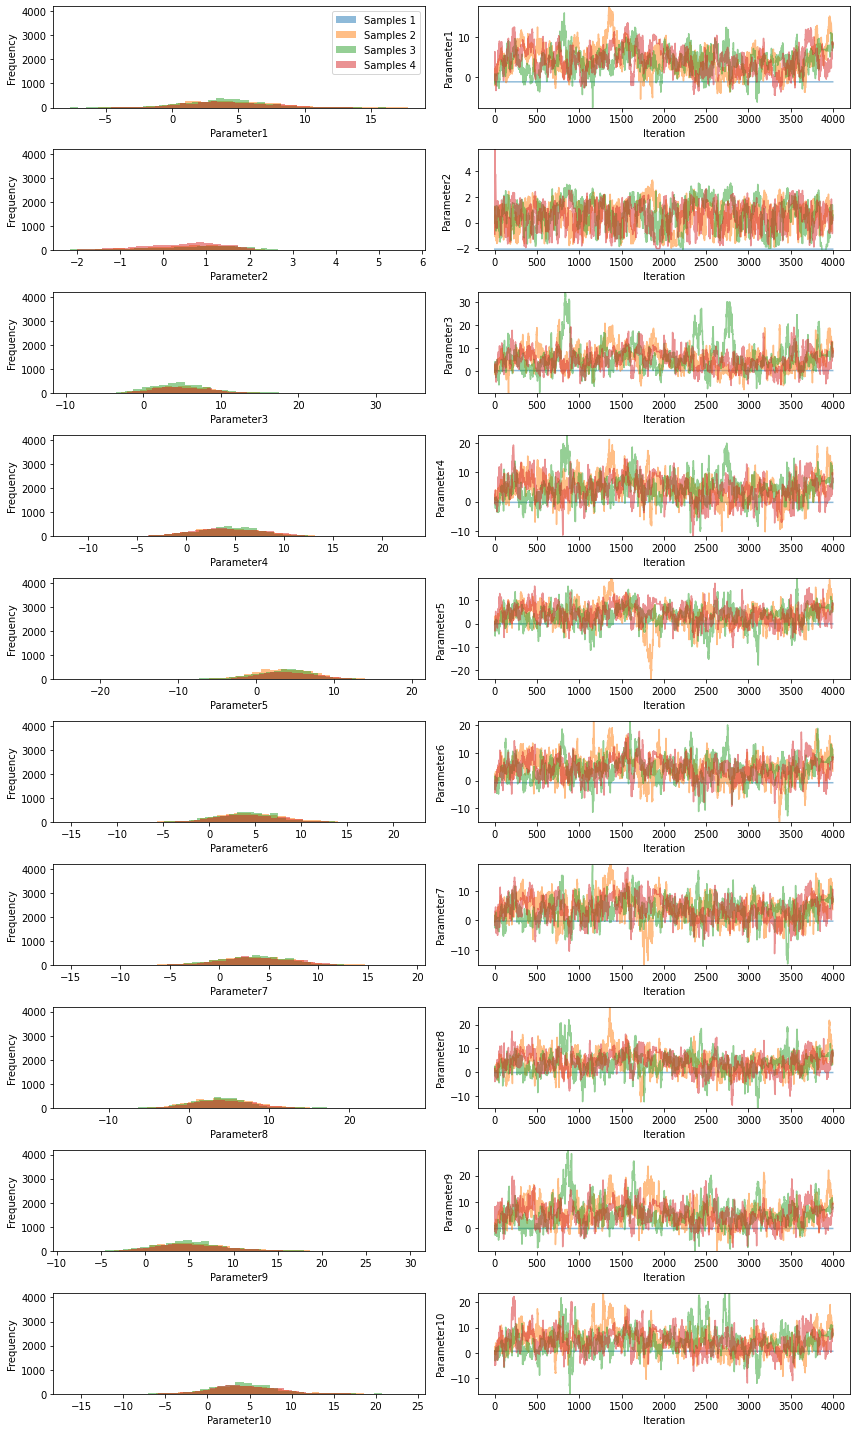

In [17]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [18]:
params = np.random.uniform(size=10)

pints_parameters = np.copy(params)
stan_parameters = np.copy(params)
# because tau is on log-scale for Stan model
stan_parameters[1] = np.log(stan_parameters[1])

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(stan_parameters))))
print(str("Pints log prob: " + str(pintsmodel(pints_parameters))))

Stan log prob: -3.1101310350236475
Pints log prob: -42.15853065998306


But the changes in parameter values should evoke proportional changes in the log-posterior.

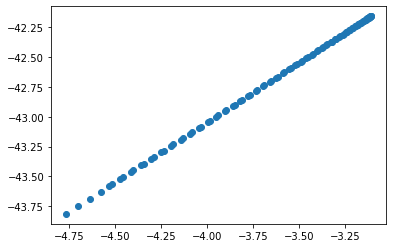

In [19]:
xs = np.linspace(0, 1, 100)
vals_stan = []
vals_pints = []
for x in xs:
    stan_parameters[0] = x
    pints_parameters[0] = x
    vals_stan.append(stanmodel(stan_parameters))
    vals_pints.append(pintsmodel(pints_parameters))
plt.plot(vals_stan, vals_pints, 'o')
plt.show()

Sensitivities however are the same because the constants disappear.

In [20]:
p1, dp1 = stanmodel.evaluateS1(stan_parameters)
p2, dp2 = pintsmodel.evaluateS1(pints_parameters)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: -5.913556833499361
Pints d log(prob)/dmu: -5.913556833499361


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [21]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Instantiate Pints version of non-centered Stan model.

In [22]:
stanmodel = StanLogPDF(stan_code=code, stan_data=model.data())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.
/usr/local/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


Retry sampling, this time with the non-centered parameterisation using PINTS' No-U-Turn sampler.

In [24]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.NoUTurnMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using No-U-Turn MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     104    0.283    10      0.351    2       0.4      1       0.4      1        0:00.0
1     108    0.25     1                                                           0:00.0
2     112    0.25     1                                                           0:00.0
3     156    0.0491   6       0.603    7       0.18428  12      0.382    12       0:00.0
400   14304  0.786    9       0.788    9       0.785    9       0.784    9        0:03.5
800   25184  0.819465 7       0.837    8       0.792    7       0.83     8        0:06.3
1200  36380  0.855    7       0.86     7       0.796    7       0.851    7        0:09.1
1600  47340  0.833    7       0.864    7       0.802728 7       0.867    7        0:11.8
2000  58144  0.828    7       0.8418   7       0.791252 7       0.841    7        0:14.6
2400  69080  0.830649 7      

Get back original parameter values: $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [25]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1).tolist())
full_chains_transformed = np.array(full_chains_transformed)

Aaaaahh, that's better...

In [26]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=stanmodel.names())
print(results)

param          mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mu             4.41    3.30    -2.01   2.18   4.42   6.60   10.92    1.00    5333.33  191.16
tau            0.79    1.19    -2.15   0.21   1.00   1.60   2.48     1.00    3674.11  131.69
theta_tilde.1  4.87    3.50    -1.95   2.55   4.85   7.20   11.83    1.00    5333.33  191.16
theta_tilde.2  4.56    3.41    -2.06   2.26   4.57   6.86   11.26    1.00    5333.33  191.16
theta_tilde.3  4.26    3.51    -2.60   1.93   4.29   6.60   11.12    1.00    5333.33  191.16
theta_tilde.4  4.50    3.41    -2.17   2.22   4.51   6.77   11.18    1.00    5333.33  191.16
theta_tilde.5  4.19    3.41    -2.48   1.94   4.20   6.45   10.79    1.00    5333.33  191.16
theta_tilde.6  4.30    3.43    -2.38   1.99   4.29   6.59   10.99    1.00    5333.33  191.16
theta_tilde.7  4.93    3.42    -1.71   2.61   4.92   7.1

...much more efficient sampling!

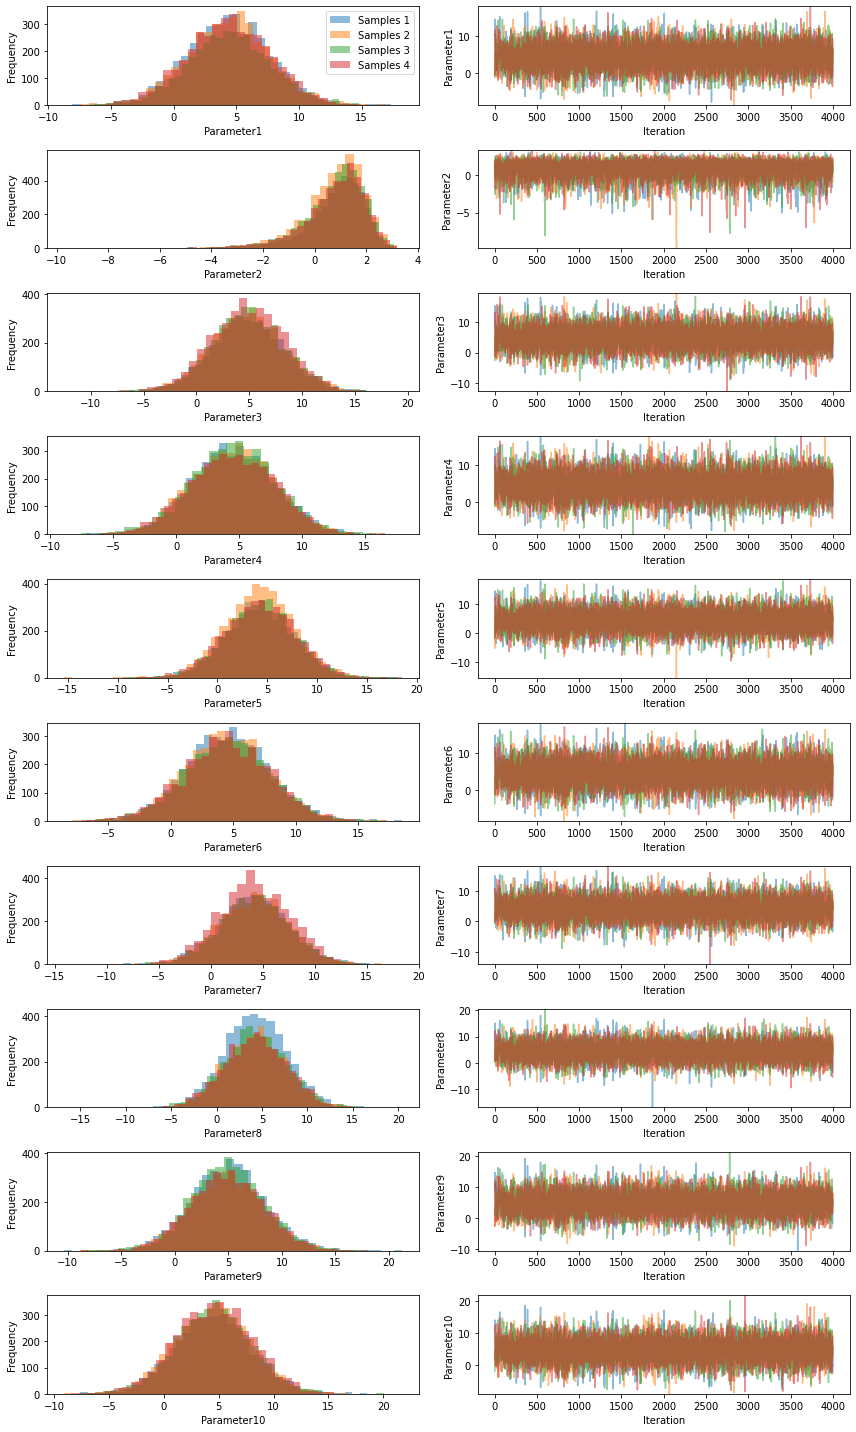

In [27]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()